In [32]:
import os
import json
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, brier_score_loss
from datasets import DatasetDict
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from glob import glob
from torch.utils.data import DataLoader

import torch.nn.functional as F

# Configuración de dispositivo (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

'cuda'

In [33]:
# @title Customize your key variables here
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 32 # @param {type:"integer"}
VALID_BATCH_SIZE = 32 # @param {type:"integer"}
EPOCHS = 6 # @param {type:"integer"}
LEARNING_RATE = 1e-5 # @param {type:"number"}

In [34]:
machines_files = glob('../data/machine/*.jsonl')
len(machines_files)

13

In [35]:
df_ids = pd.read_json('../data/human.jsonl', lines=True)
df_ids = df_ids[['id']]
df_ids["id"] = df_ids["id"].str.split('/').str[1:].str.join('/')
df_ids

,id
0,news-2021-01-01-2021-12-31-bideninauguration/a...
1,news-2021-01-01-2021-12-31-bideninauguration/a...
2,news-2021-01-01-2021-12-31-bideninauguration/a...
3,news-2021-01-01-2021-12-31-bideninauguration/a...
4,news-2021-01-01-2021-12-31-bideninauguration/a...
...,...
1082,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1083,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1084,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1085,news-2021-01-01-2021-12-31-wyominggabbypetito/...


In [36]:
train_ids_df, temp_df = train_test_split(df_ids, test_size=0.3, random_state=42)
val_ids_df, test_ids_df = train_test_split(temp_df, test_size=1/3, random_state=42)

train_ids_df.shape, val_ids_df.shape, test_ids_df.shape

((760, 1), (218, 1), (109, 1))

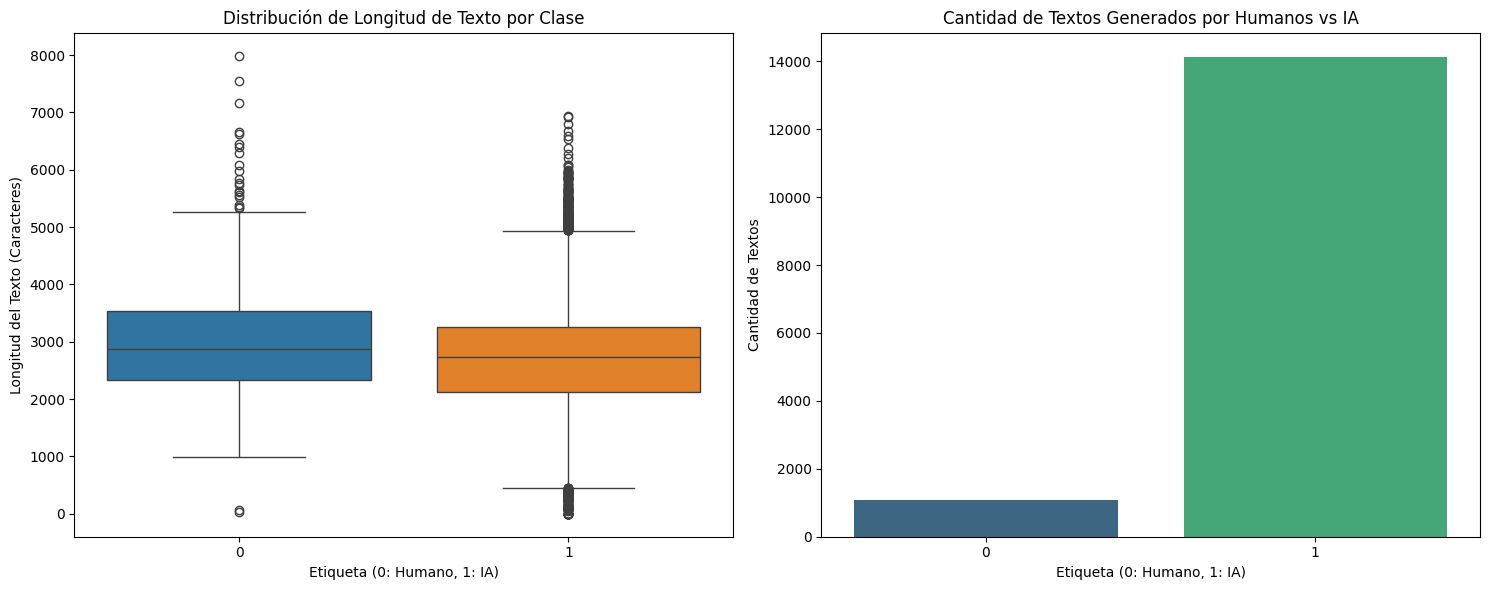

In [37]:
df_human = pd.read_json('../data/human.jsonl', lines=True)

df_human_temp = df_human.reset_index(drop=True)
df_human_temp['label'] = 0

df_machine = pd.read_json(machines_files[0], lines=True)
for file in machines_files[1:]:
    df_current = pd.read_json(file, lines=True)
    df_machine = pd.concat([df_machine, df_current])

df_machine_temp = df_machine.reset_index(drop=True)
df_machine_temp['label'] = 1


df_temp = pd.concat([df_human_temp, df_machine_temp], axis=0, ignore_index=True)

# Calcular la longitud del texto en la columna 'text'
df_temp["text_length"] = df_temp["text"].apply(len)

# Crear una figura con 2 subgráficos (uno al lado del otro)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 1. Gráfico de la longitud del texto (sin `palette`)
sns.boxplot(data=df_temp, x="label", hue="label",y="text_length", ax=ax[0], legend=False)
ax[0].set_title("Distribución de Longitud de Texto por Clase")
ax[0].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[0].set_ylabel("Longitud del Texto (Caracteres)")

# 2. Gráfico de la cantidad de texto generado por IA y Humanos
sns.countplot(data=df_temp, x="label", hue="label", palette="viridis", ax=ax[1], legend=False)
ax[1].set_title("Cantidad de Textos Generados por Humanos vs IA")
ax[1].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[1].set_ylabel("Cantidad de Textos")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [38]:
df_human["id"] = df_human["id"].str.split('/').str[1:].str.join('/')
df_machine["id"] = df_machine["id"].str.split('/').str[1:].str.join('/')

df_combined = pd.merge(df_human, df_machine, on="id", suffixes=("_1", "_2"))
df_combined['target_human'] = 1
df_combined['target_machine'] = 0
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine']]
df_combined

,id,text_1,target_human,text_2,target_machine
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Inaugural Address: President Joseph R. Biden J...,0
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address: A Clarion Call for ...,0
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0
...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Long Island Surf Shop Owner Reme...,0
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Super Kind-Heart...,0


In [39]:
random_indices = df_combined.sample(frac=0.5, random_state=42).index
df_combined.loc[random_indices, ['text_1', 'text_2']] = df_combined.loc[random_indices, ['text_2', 'text_1']].values
df_combined.loc[random_indices, ['target_human']] = 0
df_combined.loc[random_indices, ['target_machine']] = 1
df_combined['target_tuple'] = list(zip(df_combined['target_human'], df_combined['target_machine']))
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine', 'target_tuple']]
df_combined

,id,text_1,target_human,text_2,target_machine,target_tuple
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address: President Joseph R. Biden J...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0,"(1, 0)"
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0,"(1, 0)"
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Biden's Inaugural Address: A Clarion Call for ...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0,"(1, 0)"
...,...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito: Long Island Surf Shop Owner Reme...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0,"(1, 0)"
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0,"(1, 0)"
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito Remembered as a 'Super Kind-Heart...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"


In [40]:
X_train = df_combined[df_combined['id'].isin(train_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_val = df_combined[df_combined['id'].isin(val_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_test = df_combined[df_combined['id'].isin(test_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])

X_train.shape, X_val.shape, X_test.shape

((9880, 3), (2834, 3), (1417, 3))

In [41]:
X_train.sample(5)

,text_1,text_2,target_tuple
8504,Judge Denies Requests to Use Evidence Aiming t...,Kenosha County judge denies prosecutor's reque...,"(0, 1)"
10396,You're Not Getting a 4th Stimulus Check. Here'...,` Fourth Round of Federal Stimulus Checks Unli...,"(1, 0)"
5345,Evidence in Chauvin case contradicted first po...,Video Evidence Critical in Revealing Truth of ...,"(1, 0)"
3632,President Biden Unveils Bold Plan to Accelerat...,FACT SHEET: President Biden Announces Increase...,"(0, 1)"
1595,Kathy Hochul Sworn In as New York's First Fema...,Kathy Hochul becomes governor of New York as C...,"(0, 1)"


In [42]:
y_train = X_train['target_tuple']
y_val = X_val['target_tuple']
y_test = X_test['target_tuple']

X_train = X_train.drop(columns=['target_tuple'])
X_val = X_val.drop(columns=['target_tuple'])
X_test = X_test.drop(columns=['target_tuple'])

y_train.shape, y_val.shape, y_test.shape

((9880,), (2834,), (1417,))

In [43]:
X_train

,text_1,text_2
0,Inaugural Address: President Joseph R. Biden J...,Inaugural Address by President Joseph R. Biden...
1,Inaugural Address by President Joseph R. Biden...,What should be the focus of the speech? The In...
2,Inaugural Address by President Joseph R. Biden...,Biden's Inaugural Address Highlights Triumph o...
3,Biden's Inaugural Address: A Clarion Call for ...,Inaugural Address by President Joseph R. Biden...
4,Inaugural Address by President Joseph R. Biden...,"President Biden Emphasizes Unity, Democracy, a..."
...,...,...
14100,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...
14101,TESLA STOCK SOARS ON Q3 EARNINGS REPORT\n\nWYO...,Univ. of Wisconsin Oshkosh student helping Gab...
14102,WYOMING (WBAY) – A University of Wisconsin Osh...,Univ. of Wisconsin Oshkosh student helping Gab...
14103,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...


In [44]:
pd.DataFrame(y_train)

,target_tuple
0,"(0, 1)"
1,"(1, 0)"
2,"(1, 0)"
3,"(0, 1)"
4,"(1, 0)"
...,...
14100,"(1, 0)"
14101,"(0, 1)"
14102,"(0, 1)"
14103,"(1, 0)"


In [45]:
class AiClassificationDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.data = dataframe.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Use iloc to access the rows by index for data and labels
        text_1 = self.data.iloc[index]['text_1']
        text_2 = self.data.iloc[index]['text_2']
        target = self.labels.iloc[index]  # assuming labels are in a compatible format
        return {
            'text_1': text_1,
            'text_2': text_2,
            'targets': target
        }

In [46]:
class AiClassificationCollator:
    def __init__(self, dataset, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataset
        self.max_len = max_len

    def __call__(self, input_batch):
        batch_dict = {colname: [x[colname] for x in input_batch] for colname in input_batch[0]}

        # Process text_1
        comment_text_1 = batch_dict['text_1']
        comment_text_1 = [" ".join(text.split()) for text in comment_text_1]

        # Process text_2
        comment_text_2 = batch_dict['text_2']
        comment_text_2 = [" ".join(text.split()) for text in comment_text_2]

        inputs = self.tokenizer(
            comment_text_1,
            comment_text_2,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(batch_dict['targets'], dtype=torch.float)
        }

In [47]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")

In [48]:
training_set = AiClassificationDataset(X_train, y_train)
validation_set = AiClassificationDataset(X_val, y_val)
test_set = AiClassificationDataset(X_test, y_test)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(training_set, tokenizer, MAX_LEN)
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(validation_set, tokenizer, MAX_LEN)
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(test_set, tokenizer, MAX_LEN)
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

In [49]:
for batch in training_loader:
    print("Training Loader Batch:")
    if isinstance(batch, dict):  
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):  
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break  

for batch in validation_loader:
    print("\nValidation Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break

for batch in test_loader:
    print("\nTest Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break


Training Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Validation Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Test Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])


In [50]:
class TransformerClass(torch.nn.Module):
    def __init__(self):
        super(TransformerClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('google-bert/bert-large-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 256)
        self.l4 = torch.nn.Linear(256, 2)

        print("sads")

    def forward(self, ids, mask, token_type_ids):
        last_hidden_state = self.l1(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        ).last_hidden_state

        sentence_embedding = torch.sum(last_hidden_state*mask.unsqueeze(-1), 1) / torch.sum(mask.unsqueeze(-1),1)
        hidden_output = F.gelu(self.l3(self.l2(sentence_embedding)))
        output = self.l4(hidden_output)
        return output

In [51]:
def training_step(input_ids, attention_mask, token_type_ids, y, model, optimizer):
    logits = model(input_ids, attention_mask, token_type_ids)
    optimizer.zero_grad()

    loss = torch.nn.functional.cross_entropy(logits, y, reduction='mean')
    loss.backward()
    
    optimizer.step()

    return loss

In [52]:
model = TransformerClass()
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

sads


In [53]:
def validate():
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in validation_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            logits = model(input_ids, attention_mask, token_type_ids)
            val_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()  # Accumulate validation loss

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_val_loss = val_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_val_loss, accuracy


In [54]:
# Ruta del archivo de log
log_file_path = './training_log.txt'

def log_message(message):
    with open(log_file_path, 'a') as log_file:
        log_file.write(message + '\n')
    print(message)

def train(epoch, log_interval=200, save_model_path='./model_weights'):
    global best_accuracy
    model.train()
    running_loss = 0

    for step, data in enumerate(training_loader):
        input_ids = data['ids'].to(device)
        attention_mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        loss = training_step(input_ids, attention_mask, token_type_ids, targets, model, optimizer)
        running_loss += loss.item()

        # Almacenar la pérdida cada cierto número de pasos
        if step % log_interval == 0:
            avg_loss = running_loss / (step + 1)
            log_message(f"Epoch {epoch + 1}/{EPOCHS}, Step {step + 1}/{len(training_loader)}")
            log_message(f"  Running Loss: {avg_loss:.4f}")

    avg_train_loss = running_loss / len(training_loader)

    avg_val_loss, val_accuracy = validate()

    log_message(f"Epoch {epoch + 1}/{EPOCHS} - End of epoch")
    log_message(f"  Training Loss: {avg_train_loss:.4f}")
    log_message(f"  Validation Loss: {avg_val_loss:.4f}")
    log_message(f"  Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        if not os.path.exists(save_model_path):
            os.makedirs(save_model_path)

        model_save_path = os.path.join(save_model_path, f"model_epoch_{epoch + 1}_acc{best_accuracy:.4f}.pth")
        torch.save(model.state_dict(), model_save_path)
        log_message(f"Model saved to {model_save_path}")

best_accuracy = 0

# Al iniciar, limpia el archivo de log si ya existe
if os.path.exists(log_file_path):
    open(log_file_path, 'w').close()

"""Descomentar para entrenar"""
# for epoch in range(EPOCHS):
#        train(epoch)

file_path = f'..\logs\BERT_B_Embedding_training_logs.txt'

with open(file_path, 'r') as file:
    content = file.read()

print(content)

Epoch 1/6, Step 1/309
  Running Loss: 0.6925
Epoch 1/6, Step 201/309
  Running Loss: 0.3380
Epoch 1/6 - End of epoch
  Training Loss: 0.2300
  Validation Loss: 0.0292
  Validation Accuracy: 0.9912
Model saved to ./model_weights_emb/model_epoch_1_acc0.9912.pth
Epoch 2/6, Step 1/309
  Running Loss: 0.0067
Epoch 2/6, Step 201/309
  Running Loss: 0.0146
Epoch 2/6 - End of epoch
  Training Loss: 0.0126
  Validation Loss: 0.0605
  Validation Accuracy: 0.9824
Epoch 3/6, Step 1/309
  Running Loss: 0.0017
Epoch 3/6, Step 201/309
  Running Loss: 0.0033
Epoch 3/6 - End of epoch
  Training Loss: 0.0065
  Validation Loss: 0.1548
  Validation Accuracy: 0.9552
Epoch 4/6, Step 1/309
  Running Loss: 0.0084
Epoch 4/6, Step 201/309
  Running Loss: 0.0012
Epoch 4/6 - End of epoch
  Training Loss: 0.0010
  Validation Loss: 0.1823
  Validation Accuracy: 0.9647
Epoch 5/6, Step 1/309
  Running Loss: 0.0010
Epoch 5/6, Step 201/309
  Running Loss: 0.0079
Epoch 5/6 - End of epoch
  Training Loss: 0.0069
  Valida

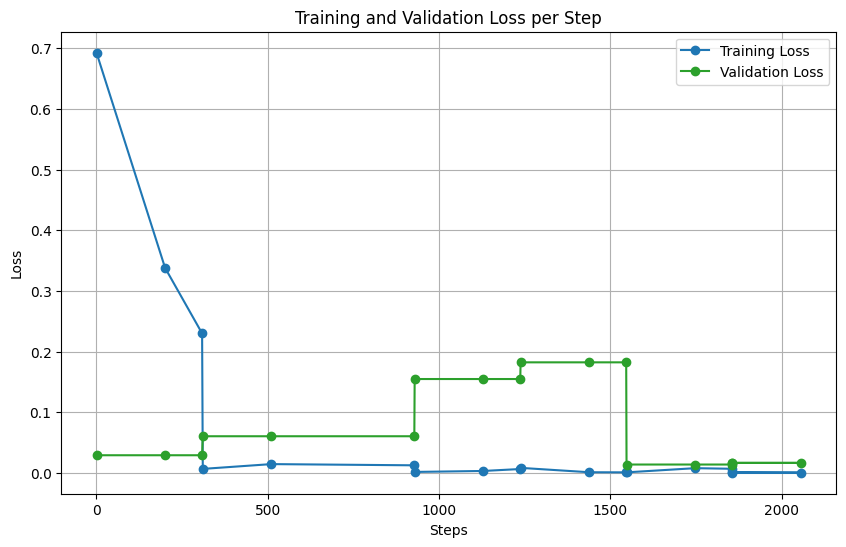

In [55]:
steps_32 = [1, 201, 309, 310 + 1, 310 + 201, 
              2 * 309 + 310, 2 * 309 + 310 + 1, 2 * 309 + 310 + 201, 
              3 * 309 + 310, 3 * 309 + 310 + 1, 3 * 309 + 310 + 201, 
              4 * 309 + 310, 4 * 309 + 310 + 1, 4 * 309 + 310 + 201,
              5 * 309 + 310, 5 * 309 + 310 + 1, 5 * 309 + 310 + 201,
              6 * 309]

losses = [
    0.6925, 0.3380, 0.2300, 
    0.0067, 0.0146, 0.0126,
    0.0017, 0.0033, 0.0065,
    0.0084, 0.0012, 0.0010,
    0.0010, 0.0079, 0.0069,
    0.0011, 0.0005, 0.0004
]

val_losses = [
    0.0292, 0.0292, 0.0292, 
    0.0605, 0.0605, 0.0605,
    0.1548, 0.1548, 0.1548,
    0.1823, 0.1823, 0.1823,
    0.0139, 0.0139, 0.0139,
    0.0166, 0.0166, 0.0166
]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(steps_32, losses, 'o-', label='Training Loss', color='tab:blue')
plt.plot(steps_32, val_losses, 'o-', label='Validation Loss', color='tab:green')

# Etiquetas y título
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Step')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [56]:
model = TransformerClass()

for name, param in model.named_parameters():
    print(f"{name}: {param.size()}")

model_save_path = f'..\model_weights\BERT_B_Embedding\model_epoch_5_acc0.9965.pth'
model.load_state_dict(torch.load(model_save_path, weights_only=False))

model.to(device)

sads
l1.embeddings.word_embeddings.weight: torch.Size([30522, 1024])
l1.embeddings.position_embeddings.weight: torch.Size([512, 1024])
l1.embeddings.token_type_embeddings.weight: torch.Size([2, 1024])
l1.embeddings.LayerNorm.weight: torch.Size([1024])
l1.embeddings.LayerNorm.bias: torch.Size([1024])
l1.encoder.layer.0.attention.self.query.weight: torch.Size([1024, 1024])
l1.encoder.layer.0.attention.self.query.bias: torch.Size([1024])
l1.encoder.layer.0.attention.self.key.weight: torch.Size([1024, 1024])
l1.encoder.layer.0.attention.self.key.bias: torch.Size([1024])
l1.encoder.layer.0.attention.self.value.weight: torch.Size([1024, 1024])
l1.encoder.layer.0.attention.self.value.bias: torch.Size([1024])
l1.encoder.layer.0.attention.output.dense.weight: torch.Size([1024, 1024])
l1.encoder.layer.0.attention.output.dense.bias: torch.Size([1024])
l1.encoder.layer.0.attention.output.LayerNorm.weight: torch.Size([1024])
l1.encoder.layer.0.attention.output.LayerNorm.bias: torch.Size([1024])
l1.

RuntimeError: Error(s) in loading state_dict for TransformerClass:
	Missing key(s) in state_dict: "l1.encoder.layer.12.attention.self.query.weight", "l1.encoder.layer.12.attention.self.query.bias", "l1.encoder.layer.12.attention.self.key.weight", "l1.encoder.layer.12.attention.self.key.bias", "l1.encoder.layer.12.attention.self.value.weight", "l1.encoder.layer.12.attention.self.value.bias", "l1.encoder.layer.12.attention.output.dense.weight", "l1.encoder.layer.12.attention.output.dense.bias", "l1.encoder.layer.12.attention.output.LayerNorm.weight", "l1.encoder.layer.12.attention.output.LayerNorm.bias", "l1.encoder.layer.12.intermediate.dense.weight", "l1.encoder.layer.12.intermediate.dense.bias", "l1.encoder.layer.12.output.dense.weight", "l1.encoder.layer.12.output.dense.bias", "l1.encoder.layer.12.output.LayerNorm.weight", "l1.encoder.layer.12.output.LayerNorm.bias", "l1.encoder.layer.13.attention.self.query.weight", "l1.encoder.layer.13.attention.self.query.bias", "l1.encoder.layer.13.attention.self.key.weight", "l1.encoder.layer.13.attention.self.key.bias", "l1.encoder.layer.13.attention.self.value.weight", "l1.encoder.layer.13.attention.self.value.bias", "l1.encoder.layer.13.attention.output.dense.weight", "l1.encoder.layer.13.attention.output.dense.bias", "l1.encoder.layer.13.attention.output.LayerNorm.weight", "l1.encoder.layer.13.attention.output.LayerNorm.bias", "l1.encoder.layer.13.intermediate.dense.weight", "l1.encoder.layer.13.intermediate.dense.bias", "l1.encoder.layer.13.output.dense.weight", "l1.encoder.layer.13.output.dense.bias", "l1.encoder.layer.13.output.LayerNorm.weight", "l1.encoder.layer.13.output.LayerNorm.bias", "l1.encoder.layer.14.attention.self.query.weight", "l1.encoder.layer.14.attention.self.query.bias", "l1.encoder.layer.14.attention.self.key.weight", "l1.encoder.layer.14.attention.self.key.bias", "l1.encoder.layer.14.attention.self.value.weight", "l1.encoder.layer.14.attention.self.value.bias", "l1.encoder.layer.14.attention.output.dense.weight", "l1.encoder.layer.14.attention.output.dense.bias", "l1.encoder.layer.14.attention.output.LayerNorm.weight", "l1.encoder.layer.14.attention.output.LayerNorm.bias", "l1.encoder.layer.14.intermediate.dense.weight", "l1.encoder.layer.14.intermediate.dense.bias", "l1.encoder.layer.14.output.dense.weight", "l1.encoder.layer.14.output.dense.bias", "l1.encoder.layer.14.output.LayerNorm.weight", "l1.encoder.layer.14.output.LayerNorm.bias", "l1.encoder.layer.15.attention.self.query.weight", "l1.encoder.layer.15.attention.self.query.bias", "l1.encoder.layer.15.attention.self.key.weight", "l1.encoder.layer.15.attention.self.key.bias", "l1.encoder.layer.15.attention.self.value.weight", "l1.encoder.layer.15.attention.self.value.bias", "l1.encoder.layer.15.attention.output.dense.weight", "l1.encoder.layer.15.attention.output.dense.bias", "l1.encoder.layer.15.attention.output.LayerNorm.weight", "l1.encoder.layer.15.attention.output.LayerNorm.bias", "l1.encoder.layer.15.intermediate.dense.weight", "l1.encoder.layer.15.intermediate.dense.bias", "l1.encoder.layer.15.output.dense.weight", "l1.encoder.layer.15.output.dense.bias", "l1.encoder.layer.15.output.LayerNorm.weight", "l1.encoder.layer.15.output.LayerNorm.bias", "l1.encoder.layer.16.attention.self.query.weight", "l1.encoder.layer.16.attention.self.query.bias", "l1.encoder.layer.16.attention.self.key.weight", "l1.encoder.layer.16.attention.self.key.bias", "l1.encoder.layer.16.attention.self.value.weight", "l1.encoder.layer.16.attention.self.value.bias", "l1.encoder.layer.16.attention.output.dense.weight", "l1.encoder.layer.16.attention.output.dense.bias", "l1.encoder.layer.16.attention.output.LayerNorm.weight", "l1.encoder.layer.16.attention.output.LayerNorm.bias", "l1.encoder.layer.16.intermediate.dense.weight", "l1.encoder.layer.16.intermediate.dense.bias", "l1.encoder.layer.16.output.dense.weight", "l1.encoder.layer.16.output.dense.bias", "l1.encoder.layer.16.output.LayerNorm.weight", "l1.encoder.layer.16.output.LayerNorm.bias", "l1.encoder.layer.17.attention.self.query.weight", "l1.encoder.layer.17.attention.self.query.bias", "l1.encoder.layer.17.attention.self.key.weight", "l1.encoder.layer.17.attention.self.key.bias", "l1.encoder.layer.17.attention.self.value.weight", "l1.encoder.layer.17.attention.self.value.bias", "l1.encoder.layer.17.attention.output.dense.weight", "l1.encoder.layer.17.attention.output.dense.bias", "l1.encoder.layer.17.attention.output.LayerNorm.weight", "l1.encoder.layer.17.attention.output.LayerNorm.bias", "l1.encoder.layer.17.intermediate.dense.weight", "l1.encoder.layer.17.intermediate.dense.bias", "l1.encoder.layer.17.output.dense.weight", "l1.encoder.layer.17.output.dense.bias", "l1.encoder.layer.17.output.LayerNorm.weight", "l1.encoder.layer.17.output.LayerNorm.bias", "l1.encoder.layer.18.attention.self.query.weight", "l1.encoder.layer.18.attention.self.query.bias", "l1.encoder.layer.18.attention.self.key.weight", "l1.encoder.layer.18.attention.self.key.bias", "l1.encoder.layer.18.attention.self.value.weight", "l1.encoder.layer.18.attention.self.value.bias", "l1.encoder.layer.18.attention.output.dense.weight", "l1.encoder.layer.18.attention.output.dense.bias", "l1.encoder.layer.18.attention.output.LayerNorm.weight", "l1.encoder.layer.18.attention.output.LayerNorm.bias", "l1.encoder.layer.18.intermediate.dense.weight", "l1.encoder.layer.18.intermediate.dense.bias", "l1.encoder.layer.18.output.dense.weight", "l1.encoder.layer.18.output.dense.bias", "l1.encoder.layer.18.output.LayerNorm.weight", "l1.encoder.layer.18.output.LayerNorm.bias", "l1.encoder.layer.19.attention.self.query.weight", "l1.encoder.layer.19.attention.self.query.bias", "l1.encoder.layer.19.attention.self.key.weight", "l1.encoder.layer.19.attention.self.key.bias", "l1.encoder.layer.19.attention.self.value.weight", "l1.encoder.layer.19.attention.self.value.bias", "l1.encoder.layer.19.attention.output.dense.weight", "l1.encoder.layer.19.attention.output.dense.bias", "l1.encoder.layer.19.attention.output.LayerNorm.weight", "l1.encoder.layer.19.attention.output.LayerNorm.bias", "l1.encoder.layer.19.intermediate.dense.weight", "l1.encoder.layer.19.intermediate.dense.bias", "l1.encoder.layer.19.output.dense.weight", "l1.encoder.layer.19.output.dense.bias", "l1.encoder.layer.19.output.LayerNorm.weight", "l1.encoder.layer.19.output.LayerNorm.bias", "l1.encoder.layer.20.attention.self.query.weight", "l1.encoder.layer.20.attention.self.query.bias", "l1.encoder.layer.20.attention.self.key.weight", "l1.encoder.layer.20.attention.self.key.bias", "l1.encoder.layer.20.attention.self.value.weight", "l1.encoder.layer.20.attention.self.value.bias", "l1.encoder.layer.20.attention.output.dense.weight", "l1.encoder.layer.20.attention.output.dense.bias", "l1.encoder.layer.20.attention.output.LayerNorm.weight", "l1.encoder.layer.20.attention.output.LayerNorm.bias", "l1.encoder.layer.20.intermediate.dense.weight", "l1.encoder.layer.20.intermediate.dense.bias", "l1.encoder.layer.20.output.dense.weight", "l1.encoder.layer.20.output.dense.bias", "l1.encoder.layer.20.output.LayerNorm.weight", "l1.encoder.layer.20.output.LayerNorm.bias", "l1.encoder.layer.21.attention.self.query.weight", "l1.encoder.layer.21.attention.self.query.bias", "l1.encoder.layer.21.attention.self.key.weight", "l1.encoder.layer.21.attention.self.key.bias", "l1.encoder.layer.21.attention.self.value.weight", "l1.encoder.layer.21.attention.self.value.bias", "l1.encoder.layer.21.attention.output.dense.weight", "l1.encoder.layer.21.attention.output.dense.bias", "l1.encoder.layer.21.attention.output.LayerNorm.weight", "l1.encoder.layer.21.attention.output.LayerNorm.bias", "l1.encoder.layer.21.intermediate.dense.weight", "l1.encoder.layer.21.intermediate.dense.bias", "l1.encoder.layer.21.output.dense.weight", "l1.encoder.layer.21.output.dense.bias", "l1.encoder.layer.21.output.LayerNorm.weight", "l1.encoder.layer.21.output.LayerNorm.bias", "l1.encoder.layer.22.attention.self.query.weight", "l1.encoder.layer.22.attention.self.query.bias", "l1.encoder.layer.22.attention.self.key.weight", "l1.encoder.layer.22.attention.self.key.bias", "l1.encoder.layer.22.attention.self.value.weight", "l1.encoder.layer.22.attention.self.value.bias", "l1.encoder.layer.22.attention.output.dense.weight", "l1.encoder.layer.22.attention.output.dense.bias", "l1.encoder.layer.22.attention.output.LayerNorm.weight", "l1.encoder.layer.22.attention.output.LayerNorm.bias", "l1.encoder.layer.22.intermediate.dense.weight", "l1.encoder.layer.22.intermediate.dense.bias", "l1.encoder.layer.22.output.dense.weight", "l1.encoder.layer.22.output.dense.bias", "l1.encoder.layer.22.output.LayerNorm.weight", "l1.encoder.layer.22.output.LayerNorm.bias", "l1.encoder.layer.23.attention.self.query.weight", "l1.encoder.layer.23.attention.self.query.bias", "l1.encoder.layer.23.attention.self.key.weight", "l1.encoder.layer.23.attention.self.key.bias", "l1.encoder.layer.23.attention.self.value.weight", "l1.encoder.layer.23.attention.self.value.bias", "l1.encoder.layer.23.attention.output.dense.weight", "l1.encoder.layer.23.attention.output.dense.bias", "l1.encoder.layer.23.attention.output.LayerNorm.weight", "l1.encoder.layer.23.attention.output.LayerNorm.bias", "l1.encoder.layer.23.intermediate.dense.weight", "l1.encoder.layer.23.intermediate.dense.bias", "l1.encoder.layer.23.output.dense.weight", "l1.encoder.layer.23.output.dense.bias", "l1.encoder.layer.23.output.LayerNorm.weight", "l1.encoder.layer.23.output.LayerNorm.bias". 
	size mismatch for l1.embeddings.word_embeddings.weight: copying a param with shape torch.Size([30522, 768]) from checkpoint, the shape in current model is torch.Size([30522, 1024]).
	size mismatch for l1.embeddings.position_embeddings.weight: copying a param with shape torch.Size([512, 768]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for l1.embeddings.token_type_embeddings.weight: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
	size mismatch for l1.embeddings.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.embeddings.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.0.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.0.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.0.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.0.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.0.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.0.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.0.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.0.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.1.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.1.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.1.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.1.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.1.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.1.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.1.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.1.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.2.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.2.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.2.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.2.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.2.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.2.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.2.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.2.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.3.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.3.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.3.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.3.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.3.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.3.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.3.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.3.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.4.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.4.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.4.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.4.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.4.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.4.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.4.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.4.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.5.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.5.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.5.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.5.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.5.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.5.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.5.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.5.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.6.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.6.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.6.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.6.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.6.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.6.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.6.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.6.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.7.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.7.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.7.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.7.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.7.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.7.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.7.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.7.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.8.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.8.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.8.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.8.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.8.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.8.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.8.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.8.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.9.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.9.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.9.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.9.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.9.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.9.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.9.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.9.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.10.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.10.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.10.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.10.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.10.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.10.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.10.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.10.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.11.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.11.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.11.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.encoder.layer.11.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.attention.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.attention.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([4096, 1024]).
	size mismatch for l1.encoder.layer.11.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([4096]).
	size mismatch for l1.encoder.layer.11.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([1024, 4096]).
	size mismatch for l1.encoder.layer.11.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.output.LayerNorm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.encoder.layer.11.output.LayerNorm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for l1.pooler.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([1024, 1024]).
	size mismatch for l1.pooler.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([1024]).

In [ ]:
def test(test_loader, model, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for data in test_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, token_type_ids)
            test_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()

            # Predicciones y probabilidades
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Acumulamos
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Probabilidades de clase positiva
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.argmax(dim=1).cpu().numpy())  # Para multi-clase, usa el índice

            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_test_loss = test_loss / total_predictions
    accuracy = correct_predictions / total_predictions

    # Métricas adicionales
    roc_auc = roc_auc_score(all_targets, all_probs)
    brier = brier_score_loss(all_targets, all_probs)
    f1 = f1_score(all_targets, all_preds, average='weighted')  # Ajusta el promedio si es necesario
    f05 = precision_recall_fscore_support(all_targets, all_preds, average='weighted', beta=0.5)[2]

    # C@1
    correct = sum(1 for t, p in zip(all_targets, all_preds) if t == p)
    c_at_1 = correct / len(all_preds)

    return avg_test_loss, accuracy, roc_auc, brier, c_at_1, f1, f05


# Ejemplo de uso
test_loss, test_accuracy, roc_auc, brier, c_at_1, f1, f05 = test(test_loader, model, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"C@1: {c_at_1:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F0.5 Score: {f05:.4f}")

Test Loss: 0.0145
Test Accuracy: 0.9951
ROC-AUC: 0.9999
Brier Score: 0.0041
C@1: 0.9951
F1 Score: 0.9951
F0.5 Score: 0.9951
